In [1]:
import json
import os
import nibabel as nb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.patches as mpatches
import cv2
from pymongo import MongoClient
import pymongo
import pandas as pd

In [2]:
cur_dir = os.getcwd()
json_path = os.path.abspath(os.path.join(cur_dir, os.pardir, 'datasets\\Task01_BrainTumour\\dataset.json'))
with open(json_path) as json_file:
    metadata = json.load(json_file)

In [3]:
def data_load(ind):

    print(metadata['training'][ind])

    image_path = os.path.abspath(os.path.join(cur_dir, os.pardir, 'datasets\\Task01_BrainTumour', metadata['training'][ind]['image']))
    img = nb.load(image_path)

    label_path = os.path.abspath(os.path.join(cur_dir, os.pardir, 'datasets\\Task01_BrainTumour', metadata['training'][ind]['label']))
    lab = nb.load(label_path)

    img0 = img.get_fdata()
    lab0 = lab.get_fdata()

    name_img = metadata['training'][ind]['label'].split('/')[-1].split('.')[0]
    
    return img0, lab0, name_img

In [4]:
client = MongoClient("localhost:27017") # Initialize the mongodb client - No argument means default localhost connection
db = client["aswin_image_segmentation"] # Name of the DB
results = db["training_data"]

In [5]:
db["training_data"].create_index([('img_name', pymongo.ASCENDING)], unique=True)

'img_name_1'

In [6]:
def crop_image_v2(image, label_image):
    size = 64
    
    a = image.shape[0]//2 - size
    b = image.shape[0]//2 + size
    c = image.shape[1]//2 - size
    d = image.shape[1]//2 + size
    
    return image[a:b, c:d], label_image[a:b, c:d]

In [7]:
def crop_image_cv(image, label_image):
    size = 64
    
#     image[image > 0] = 1
    
    M = cv2.moments(image[:,:,0])
    
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
#     print(cX, cY)
    
    if image.shape[0] <= image.shape[1]:
        a = min(cX,cY) - size
        b = min(cX,cY) + size

        c = max(cX,cY) - size
        d = max(cX,cY) + size
    
    else:
        a = max(cX,cY) - size
        b = max(cX,cY) + size

        c = min(cX,cY) - size
        d = min(cX,cY) + size
    
    return image[a:b, c:d], label_image[a:b, c:d]

In [8]:
def save_to_db_v2(img, lab, name, slice_num, axis_num):
    test_img = img[:,:,0].copy()
    test_label = lab.copy()
    
    test_label[test_img > 0] += 1
    
    results.insert_one(
    {
        "img_name" : name + '_' + str(slice_num) + '_' + str(axis_num),
        "image" : img.tolist(),
        "label" : test_label.tolist(),
        "slice_axis" : axis_num
    }
    )

In [9]:
def data_slicer_v3(img, lab, name):
    
    count = 0
        
    axis_num = 0
    for layer in range(img.shape[0]):
        zero_ratio = np.count_nonzero(img[layer, :, :, :]==0)/img[layer, :, :, :].size
        if img[layer, :, :, :].max() > 0.0 and lab[layer, :, :].max() > 0.0 and zero_ratio < 0.6 and lab[layer, :, :].sum() > 1000:

            try:
                crpd_img, crpd_lab = crop_image_cv(img[layer, :, :, :], lab[layer, :, :])
                if crpd_img.shape == (128,128,4):
                    save_to_db_v2(crpd_img, crpd_lab, name, layer, axis_num)
                    count+=1
            except Exception as e:
                print(e)
                pass

    axis_num = 1
    for layer in range(img.shape[1]):
        zero_ratio = np.count_nonzero(img[:, layer, :, :]==0)/img[:, layer, :, :].size
        if img[:, layer, :, :].max() > 0.0 and lab[:, layer, :].max() > 0.0 and zero_ratio < 0.6 and lab[layer, :, :].sum() > 1000:
            
            try:
                crpd_img, crpd_lab = crop_image_cv(img[:, layer, :, :], lab[:, layer, :])
                if crpd_img.shape == (128,128,4):
                    save_to_db_v2(crpd_img, crpd_lab, name, layer, axis_num)
                    count+=1
            except Exception as e:
                print(e)
                pass

    axis_num = 2
    for layer in range(img.shape[2]):
        zero_ratio = np.count_nonzero(img[:, :, layer, :]==0)/img[:, :, layer, :].size
        if img[:, :, layer, :].max() > 0.0 and lab[:, :, layer].max() > 0.0 and zero_ratio < 0.7 and lab[layer, :, :].sum() > 1000:
            
            try:
                crpd_img, crpd_lab = crop_image_v2(img[:, :, layer, :], lab[:, :, layer])
                if crpd_img.shape == (128,128,4):
                    save_to_db_v2(crpd_img, crpd_lab, name, layer, axis_num)
                    count+=1
            except Exception as e:
                print(e)
                pass
    
    print("Name:", name, "-", "Out of", (sum(img.shape[0:3])), "images", count, "images were saved to DB!")

In [10]:
# with complex cv and auto centre

In [11]:
metadata['numTraining']

484

In [12]:
for ind in range(metadata['numTraining']): #np.random.randint(0,metadata['numTraining'], 1):
    img, lab, name = data_load(ind)

    try:
        data_slicer_v3(img, lab, name)
    except Exception as e:
        print(e)
        print("Duplicate data can't be saved!")

{'image': './imagesTr/BRATS_457.nii.gz', 'label': './labelsTr/BRATS_457.nii.gz'}
Name: BRATS_457 - Out of 635 images 27 images were saved to DB!
{'image': './imagesTr/BRATS_306.nii.gz', 'label': './labelsTr/BRATS_306.nii.gz'}
Name: BRATS_306 - Out of 635 images 25 images were saved to DB!
{'image': './imagesTr/BRATS_206.nii.gz', 'label': './labelsTr/BRATS_206.nii.gz'}
Name: BRATS_206 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_449.nii.gz', 'label': './labelsTr/BRATS_449.nii.gz'}
Name: BRATS_449 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_318.nii.gz', 'label': './labelsTr/BRATS_318.nii.gz'}
Name: BRATS_318 - Out of 635 images 60 images were saved to DB!
{'image': './imagesTr/BRATS_218.nii.gz', 'label': './labelsTr/BRATS_218.nii.gz'}
Name: BRATS_218 - Out of 635 images 24 images were saved to DB!
{'image': './imagesTr/BRATS_434.nii.gz', 'label': './labelsTr/BRATS_434.nii.gz'}
Name: BRATS_434 - Out of 635 images 27 images were 

Name: BRATS_005 - Out of 635 images 5 images were saved to DB!
{'image': './imagesTr/BRATS_178.nii.gz', 'label': './labelsTr/BRATS_178.nii.gz'}
Name: BRATS_178 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_078.nii.gz', 'label': './labelsTr/BRATS_078.nii.gz'}
Name: BRATS_078 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_480.nii.gz', 'label': './labelsTr/BRATS_480.nii.gz'}
Name: BRATS_480 - Out of 635 images 6 images were saved to DB!
{'image': './imagesTr/BRATS_166.nii.gz', 'label': './labelsTr/BRATS_166.nii.gz'}
Name: BRATS_166 - Out of 635 images 16 images were saved to DB!
{'image': './imagesTr/BRATS_066.nii.gz', 'label': './labelsTr/BRATS_066.nii.gz'}
Name: BRATS_066 - Out of 635 images 129 images were saved to DB!
{'image': './imagesTr/BRATS_040.nii.gz', 'label': './labelsTr/BRATS_040.nii.gz'}
Name: BRATS_040 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_140.nii.gz', 'label': './labelsTr/BRATS_14

Name: BRATS_232 - Out of 635 images 4 images were saved to DB!
{'image': './imagesTr/BRATS_085.nii.gz', 'label': './labelsTr/BRATS_085.nii.gz'}
Name: BRATS_085 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_089.nii.gz', 'label': './labelsTr/BRATS_089.nii.gz'}
Name: BRATS_089 - Out of 635 images 29 images were saved to DB!
{'image': './imagesTr/BRATS_189.nii.gz', 'label': './labelsTr/BRATS_189.nii.gz'}
Name: BRATS_189 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_243.nii.gz', 'label': './labelsTr/BRATS_243.nii.gz'}
Name: BRATS_243 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_412.nii.gz', 'label': './labelsTr/BRATS_412.nii.gz'}
Name: BRATS_412 - Out of 635 images 25 images were saved to DB!
{'image': './imagesTr/BRATS_343.nii.gz', 'label': './labelsTr/BRATS_343.nii.gz'}
Name: BRATS_343 - Out of 635 images 32 images were saved to DB!
{'image': './imagesTr/BRATS_097.nii.gz', 'label': './labelsTr/BRATS_09

Name: BRATS_081 - Out of 635 images 14 images were saved to DB!
{'image': './imagesTr/BRATS_363.nii.gz', 'label': './labelsTr/BRATS_363.nii.gz'}
Name: BRATS_363 - Out of 635 images 9 images were saved to DB!
{'image': './imagesTr/BRATS_432.nii.gz', 'label': './labelsTr/BRATS_432.nii.gz'}
Name: BRATS_432 - Out of 635 images 53 images were saved to DB!
{'image': './imagesTr/BRATS_263.nii.gz', 'label': './labelsTr/BRATS_263.nii.gz'}
Name: BRATS_263 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_300.nii.gz', 'label': './labelsTr/BRATS_300.nii.gz'}
Name: BRATS_300 - Out of 635 images 20 images were saved to DB!
{'image': './imagesTr/BRATS_451.nii.gz', 'label': './labelsTr/BRATS_451.nii.gz'}
Name: BRATS_451 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_200.nii.gz', 'label': './labelsTr/BRATS_200.nii.gz'}
Name: BRATS_200 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_271.nii.gz', 'label': './labelsTr/BRATS_27

Name: BRATS_158 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_025.nii.gz', 'label': './labelsTr/BRATS_025.nii.gz'}
Name: BRATS_025 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_292.nii.gz', 'label': './labelsTr/BRATS_292.nii.gz'}
Name: BRATS_292 - Out of 635 images 24 images were saved to DB!
{'image': './imagesTr/BRATS_125.nii.gz', 'label': './labelsTr/BRATS_125.nii.gz'}
Name: BRATS_125 - Out of 635 images 12 images were saved to DB!
{'image': './imagesTr/BRATS_392.nii.gz', 'label': './labelsTr/BRATS_392.nii.gz'}
Name: BRATS_392 - Out of 635 images 13 images were saved to DB!
{'image': './imagesTr/BRATS_046.nii.gz', 'label': './labelsTr/BRATS_046.nii.gz'}
Name: BRATS_046 - Out of 635 images 13 images were saved to DB!
{'image': './imagesTr/BRATS_146.nii.gz', 'label': './labelsTr/BRATS_146.nii.gz'}
Name: BRATS_146 - Out of 635 images 13 images were saved to DB!
{'image': './imagesTr/BRATS_380.nii.gz', 'label': './labelsTr/BRATS_

Name: BRATS_331 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_460.nii.gz', 'label': './labelsTr/BRATS_460.nii.gz'}
Name: BRATS_460 - Out of 635 images 2 images were saved to DB!
{'image': './imagesTr/BRATS_186.nii.gz', 'label': './labelsTr/BRATS_186.nii.gz'}
Name: BRATS_186 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_264.nii.gz', 'label': './labelsTr/BRATS_264.nii.gz'}
Name: BRATS_264 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_435.nii.gz', 'label': './labelsTr/BRATS_435.nii.gz'}
Name: BRATS_435 - Out of 635 images 25 images were saved to DB!
{'image': './imagesTr/BRATS_364.nii.gz', 'label': './labelsTr/BRATS_364.nii.gz'}
Name: BRATS_364 - Out of 635 images 28 images were saved to DB!
{'image': './imagesTr/BRATS_219.nii.gz', 'label': './labelsTr/BRATS_219.nii.gz'}
Name: BRATS_219 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_448.nii.gz', 'label': './labelsTr/BRATS_448

Name: BRATS_006 - Out of 635 images 6 images were saved to DB!
{'image': './imagesTr/BRATS_106.nii.gz', 'label': './labelsTr/BRATS_106.nii.gz'}
Name: BRATS_106 - Out of 635 images 28 images were saved to DB!
{'image': './imagesTr/BRATS_065.nii.gz', 'label': './labelsTr/BRATS_065.nii.gz'}
Name: BRATS_065 - Out of 635 images 67 images were saved to DB!
{'image': './imagesTr/BRATS_483.nii.gz', 'label': './labelsTr/BRATS_483.nii.gz'}
Name: BRATS_483 - Out of 635 images 1 images were saved to DB!
{'image': './imagesTr/BRATS_165.nii.gz', 'label': './labelsTr/BRATS_165.nii.gz'}
Name: BRATS_165 - Out of 635 images 2 images were saved to DB!
{'image': './imagesTr/BRATS_018.nii.gz', 'label': './labelsTr/BRATS_018.nii.gz'}
Name: BRATS_018 - Out of 635 images 26 images were saved to DB!
{'image': './imagesTr/BRATS_118.nii.gz', 'label': './labelsTr/BRATS_118.nii.gz'}
Name: BRATS_118 - Out of 635 images 16 images were saved to DB!
{'image': './imagesTr/BRATS_169.nii.gz', 'label': './labelsTr/BRATS_1

Name: BRATS_329 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_254.nii.gz', 'label': './labelsTr/BRATS_254.nii.gz'}
Name: BRATS_254 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_405.nii.gz', 'label': './labelsTr/BRATS_405.nii.gz'}
Name: BRATS_405 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_354.nii.gz', 'label': './labelsTr/BRATS_354.nii.gz'}
Name: BRATS_354 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_283.nii.gz', 'label': './labelsTr/BRATS_283.nii.gz'}
Name: BRATS_283 - Out of 635 images 6 images were saved to DB!
{'image': './imagesTr/BRATS_034.nii.gz', 'label': './labelsTr/BRATS_034.nii.gz'}
Name: BRATS_034 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_383.nii.gz', 'label': './labelsTr/BRATS_383.nii.gz'}
Name: BRATS_383 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_134.nii.gz', 'label': './labelsTr/BRATS_134.n

Name: BRATS_260 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_360.nii.gz', 'label': './labelsTr/BRATS_360.nii.gz'}
Name: BRATS_360 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_431.nii.gz', 'label': './labelsTr/BRATS_431.nii.gz'}
Name: BRATS_431 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_203.nii.gz', 'label': './labelsTr/BRATS_203.nii.gz'}
Name: BRATS_203 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_303.nii.gz', 'label': './labelsTr/BRATS_303.nii.gz'}
Name: BRATS_303 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_452.nii.gz', 'label': './labelsTr/BRATS_452.nii.gz'}
Name: BRATS_452 - Out of 635 images 0 images were saved to DB!
{'image': './imagesTr/BRATS_256.nii.gz', 'label': './labelsTr/BRATS_256.nii.gz'}
Name: BRATS_256 - Out of 635 images 23 images were saved to DB!
{'image': './imagesTr/BRATS_407.nii.gz', 'label': './labelsTr/BRATS_407.

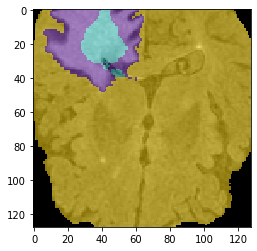

Slice Axis:  2
Label Sum:  18122.0
0.07861328125


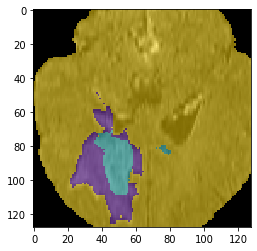

Slice Axis:  1
Label Sum:  16626.0
0.1378173828125


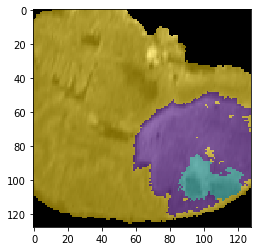

Slice Axis:  0
Label Sum:  18197.0
0.167236328125


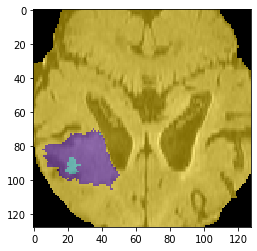

Slice Axis:  1
Label Sum:  15726.0
0.10382080078125


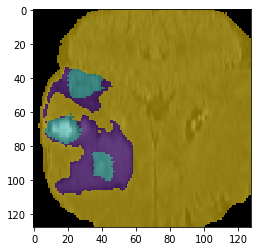

Slice Axis:  1
Label Sum:  17715.0
0.1227874755859375


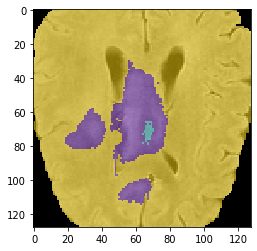

Slice Axis:  2
Label Sum:  16864.0
0.085693359375


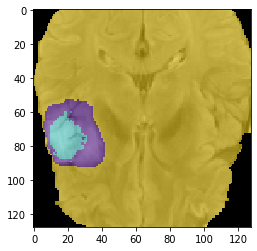

Slice Axis:  2
Label Sum:  16046.0
0.11444091796875


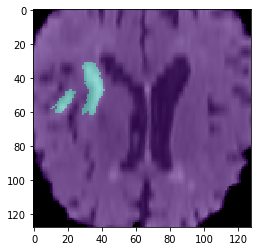

Slice Axis:  2
Label Sum:  15516.0
0.0769805908203125


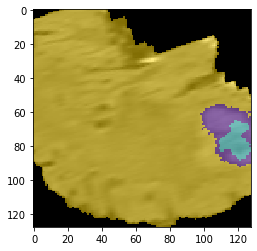

Slice Axis:  0
Label Sum:  14429.0
0.19549560546875


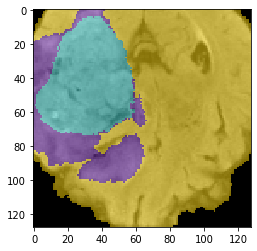

Slice Axis:  2
Label Sum:  24148.0
0.103973388671875


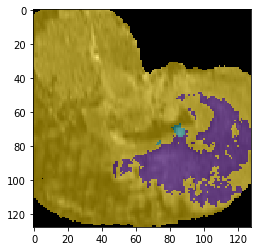

Slice Axis:  0
Label Sum:  15538.0
0.19268798828125


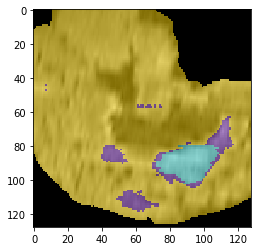

Slice Axis:  0
Label Sum:  15087.0
0.21185302734375


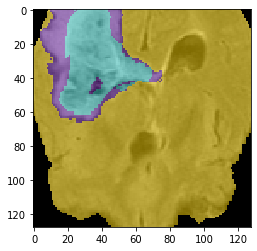

Slice Axis:  2
Label Sum:  20690.0
0.0982666015625


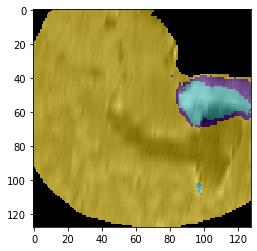

Slice Axis:  0
Label Sum:  15653.0
0.17462158203125


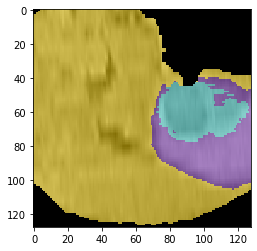

Slice Axis:  0
Label Sum:  18397.0
0.1921539306640625


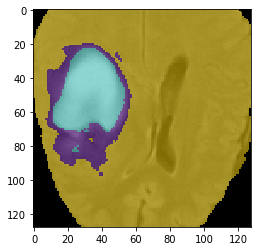

Slice Axis:  2
Label Sum:  19157.0
0.0947265625


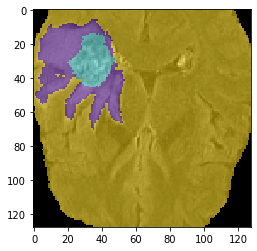

Slice Axis:  2
Label Sum:  17882.0
0.0919189453125


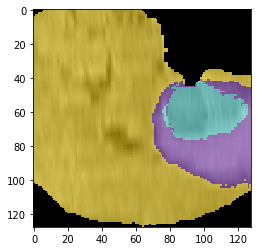

Slice Axis:  0
Label Sum:  18009.0
0.1899261474609375


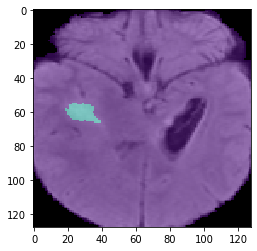

Slice Axis:  1
Label Sum:  14811.0
0.1063385009765625


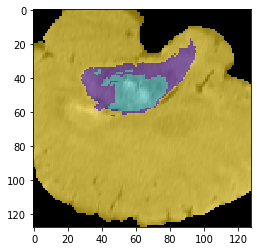

Slice Axis:  0
Label Sum:  16184.0
0.16973876953125


In [13]:
one = results.aggregate(
   [ { '$sample': { 'size': 20 } } ]
)

c = 20

while c > 0:
    temp = one.next()
    colors = ['none','gold', 'indigo', 'lightseagreen']
    cmap = matplotlib.colors.ListedColormap(colors)
    plt.imshow(np.array(temp['image'])[:,:,0].T, cmap='gray')
    plt.imshow(np.array(temp['label']).T, alpha=0.5, cmap=cmap)
    plt.show()
    
    print('Slice Axis: ', temp['slice_axis'])
    
    print('Label Sum: ',np.array(temp['label']).sum())
    

    print(np.count_nonzero(np.array(temp['image']) == 0)/np.array(temp['image']).size)
    c-=1

In [14]:
results.estimated_document_count()

5329

In [ ]:
client = MongoClient("localhost:27017") # Initialize the mongodb client - No argument means default localhost connection
db = client["brain_tumour_data"] # Name of the DB
results = db["training_data"]

In [15]:
collections = results.find()

img_name_list = list()

for col in collections:
    img_name_list.append(col['img_name'])

print(len(img_name_list))

img_name_df = pd.DataFrame({"image_name" : img_name_list})

img_name_df.to_csv('image_name_info_apr_20.csv', index=False)

5329
